In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import skew, kurtosis

from src.universe import Universe
from src.utils import time_series_generator
from src.metrics import plot_mse, generate_report
from src.model.deepar import DeepAR
from src.model.cnn1d import CNN1D
from src.model.transformer import Transformer

2023-04-27 23:58:49.837348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inception_date = '2022-03-31'
ONE_YEAR_TRADE_DAYS = 252
TWO_YEAR_TRADE_DAYS = ONE_YEAR_TRADE_DAYS * 2
WIN_LEN = 30
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16

In [3]:
universe = Universe()

### Dataset 1, use raw return from Top 2500 liquid ticker before 2022-03-31 and predict the following year (till 2023-03-31)

In [4]:
liquid_ticker_ret = universe.get_liquid_ticker_return('2022-03-31')

/Users/guzhicheng/Desktop/HKUST_course/Spring/6000M/proj2/src/universe.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  universe = pd.read_csv(self._root / f'{inception_date}.csv', squeeze=True)
100%|██████████| 2500/2500 [00:08<00:00, 310.60it/s]


### loading the past 2 years training data

<Axes: ylabel='Density'>

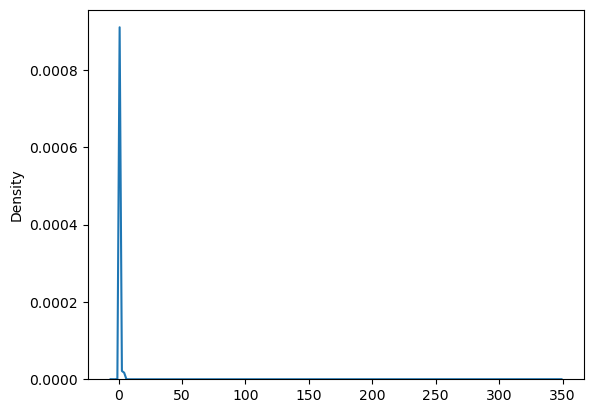

In [5]:
ret_train = liquid_ticker_ret.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS-WIN_LEN:]
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
train_flat = ret_train.values.flatten()
train_flat = train_flat[train_flat != 0]
sns.kdeplot(train_flat)

In [6]:
skew(train_flat), kurtosis(train_flat, fisher=True)

(925.5984680449808, 932863.0520740927)

<Axes: ylabel='Density'>

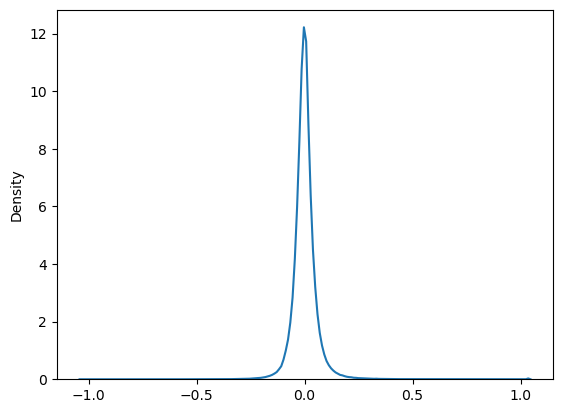

In [7]:
## clip data to reduce outliers effect
m = train_flat.mean()
s = train_flat.std()
train_flat = train_flat.clip(m-3*s, m+3*s)
sns.kdeplot(train_flat)

In [8]:
skew(train_flat), kurtosis(train_flat, fisher=True)

(3.0721249044539727, 49.61270958237107)

In [9]:
ret_train = ret_train.clip(m-3*s, m+3*s)
X, y = time_series_generator(ret_train, WIN_LEN)
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((378, 30, 2500), (126, 30, 2500), (378, 2500), (126, 2500))

In [10]:
## test set
test_start_date = liquid_ticker_ret.loc[:inception_date].iloc[-WIN_LEN:].index[0]
ret_test = liquid_ticker_ret.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN+1]
ret_test = ret_test.clip(m-3*s, m+3*s)
X_test, y_test = time_series_generator(ret_test, WIN_LEN)
test_index = ret_test.loc[inception_date:].iloc[1:ONE_YEAR_TRADE_DAYS].index

In [11]:
### define callback
esc = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='auto',
)

### Last Frame Prediction

In [12]:
y_pred_train_lf = X[:, -1, :]
y_pred_test_lf = X_test[:, -1, :]

In [13]:
## mean reversion assumption, return will flip tomorrow
y_pred_train_lfmr = -y_pred_train_lf
y_pred_test_lfmr = -y_pred_test_lf

### LSTM

In [14]:
lstm_cov = keras.Sequential([
    layers.LSTM(256, dropout=.1, activation='relu', return_sequences=False),
    layers.Dense(UNIVERSE_SIZE),
])
lstm_cov.compile(
    optimizer='rmsprop',
    loss='mse',
)
lstm_cov.build(input_shape=(BATCH_SIZE, WIN_LEN, UNIVERSE_SIZE))
lstm_cov.summary()


2023-04-27 23:59:06.999039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  2823168   
                                                                 
 dense (Dense)               multiple                  642500    
                                                                 
Total params: 3,465,668
Trainable params: 3,465,668
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_lstm_cov = lstm_cov.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
    callbacks=[esc, tf.keras.callbacks.ModelCheckpoint('./model/lstm_cov/', monitor='val_loss')]
    )
    

Train on 378 samples, validate on 126 samples
Epoch 1/20


2023-04-27 23:59:08.337998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


378/378 [==============================] - ETA: 0s - loss: 0.0029

/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: ./model/lstm_cov/assets
378/378 [==============================] - 6s 17ms/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 2/20
378/378 [==============================] - 6s 16ms/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 3/20
378/378 [==============================] - 7s 18ms/sample - loss: 0.0027 - val_loss: 0.0028


### CNN1D

In [16]:
cnn1d = CNN1D(WIN_LEN, UNIVERSE_SIZE)
cnn1d.build_and_compile()
cnn1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 2500)]        0         
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            240032    
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 512)           33280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 512)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 320)           491840    
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                             

In [17]:
history_cnn1d = cnn1d.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
    callbacks=[esc, tf.keras.callbacks.ModelCheckpoint('./model/cnn1d/', monitor='val_loss')]
    )
    

Train on 378 samples, validate on 126 samples
Epoch 1/20
368/378 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0028

/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: ./model/cnn1d/assets


INFO:tensorflow:Assets written to: ./model/cnn1d/assets


378/378 [==============================] - 3s 7ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/20
368/378 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0028

INFO:tensorflow:Assets written to: ./model/cnn1d/assets


INFO:tensorflow:Assets written to: ./model/cnn1d/assets


378/378 [==============================] - 3s 7ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
368/378 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0028

INFO:tensorflow:Assets written to: ./model/cnn1d/assets


INFO:tensorflow:Assets written to: ./model/cnn1d/assets


378/378 [==============================] - 3s 8ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027


### Transformer

In [18]:
transformer = Transformer(WIN_LEN, UNIVERSE_SIZE)
transformer.build_and_compile()
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 2500)]   0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 30, 480)      5723520     ['input_2[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  ((None, 30, 480),   738912      ['lstm_1[0][0]',                 
 dAttention)                     (None, 3, 30, 30))               'lstm_1[0][0]',                 
                                                                  'lstm_1[0][0]']                 
                                                                                            

In [19]:
history_transformer = transformer.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
    callbacks=[esc, tf.keras.callbacks.ModelCheckpoint('./model/transformer/', monitor='val_loss')]
    )
    

Train on 378 samples, validate on 126 samples
Epoch 1/20
378/378 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: ./model/transformer/assets


INFO:tensorflow:Assets written to: ./model/transformer/assets


378/378 [==============================] - 13s 34ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/20
378/378 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

INFO:tensorflow:Assets written to: ./model/transformer/assets


INFO:tensorflow:Assets written to: ./model/transformer/assets


378/378 [==============================] - 11s 29ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
378/378 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

INFO:tensorflow:Assets written to: ./model/transformer/assets


INFO:tensorflow:Assets written to: ./model/transformer/assets


378/378 [==============================] - 10s 26ms/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0028


### DeepAR

In [20]:
deepar = DeepAR(WIN_LEN, UNIVERSE_SIZE)
deepar.build_and_compile()
deepar.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 2500)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 248)               2727008   
                                                                 
 dense_5 (Dense)             (None, 35)                8715      
                                                                 
 gaussian_layer (GaussianLay  ((None, 2500),           180000    
 er)                          (None, 2500))                      
                                                                 
Total params: 2,915,723
Trainable params: 2,915,723
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_deepar = deepar.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
    callbacks=[esc, tf.keras.callbacks.ModelCheckpoint('./model/deepar/', monitor='val_loss')]
    )
    

Train on 378 samples, validate on 126 samples
Epoch 1/20
378/378 [==============================] - ETA: 0s - loss: -0.4253 - mse: 0.0117

/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 8s 22ms/sample - loss: -0.4253 - mse: 0.0117 - val_loss: -0.5293 - val_mse: 0.0109
Epoch 2/20
378/378 [==============================] - ETA: 0s - loss: -1.0484 - mse: 0.0058INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 7s 18ms/sample - loss: -1.0484 - mse: 0.0058 - val_loss: -0.9066 - val_mse: 0.0088
Epoch 3/20
378/378 [==============================] - ETA: 0s - loss: -1.2025 - mse: 0.0051INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 7s 19ms/sample - loss: -1.2025 - mse: 0.0051 - val_loss: -0.9898 - val_mse: 0.0073
Epoch 4/20
378/378 [==============================] - ETA: 0s - loss: -1.2382 - mse: 0.0049INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 6s 15ms/sample - loss: -1.2382 - mse: 0.0049 - val_loss: -1.1012 - val_mse: 0.0063
Epoch 5/20
378/378 [==============================] - ETA: 0s - loss: -1.2820 - mse: 0.0046INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 6s 16ms/sample - loss: -1.2820 - mse: 0.0046 - val_loss: -1.2442 - val_mse: 0.0044
Epoch 6/20
378/378 [==============================] - ETA: 0s - loss: -1.3248 - mse: 0.0043INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 7s 18ms/sample - loss: -1.3248 - mse: 0.0043 - val_loss: -1.4213 - val_mse: 0.0031
Epoch 7/20
378/378 [==============================] - ETA: 0s - loss: -1.3552 - mse: 0.0041INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 7s 20ms/sample - loss: -1.3552 - mse: 0.0041 - val_loss: -1.4986 - val_mse: 0.0030
Epoch 8/20
368/378 [============================>.] - ETA: 0s - loss: -1.3932 - mse: 0.0040INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 6s 15ms/sample - loss: -1.3963 - mse: 0.0040 - val_loss: -1.5199 - val_mse: 0.0033
Epoch 9/20
378/378 [==============================] - ETA: 0s - loss: -1.4050 - mse: 0.0039INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 7s 18ms/sample - loss: -1.4050 - mse: 0.0039 - val_loss: -1.2395 - val_mse: 0.0050
Epoch 10/20
378/378 [==============================] - ETA: 0s - loss: -1.4231 - mse: 0.0039INFO:tensorflow:Assets written to: ./model/deepar/assets


INFO:tensorflow:Assets written to: ./model/deepar/assets


378/378 [==============================] - 6s 17ms/sample - loss: -1.4231 - mse: 0.0039 - val_loss: -1.4162 - val_mse: 0.0038


In [22]:
y_pred_train_lstm = lstm_cov.predict(X)
y_pred_test_lstm = lstm_cov.predict(X_test)

y_pred_train_cnn1d = cnn1d.predict(X)
y_pred_test_cnn1d = cnn1d.predict(X_test)

y_pred_train_transformer = transformer.predict(X)
y_pred_test_transformer = transformer.predict(X_test)

y_pred_train_deepar = deepar.predict_mu(X)
y_pred_test_deepar = deepar.predict_mu(X_test)

/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## train result

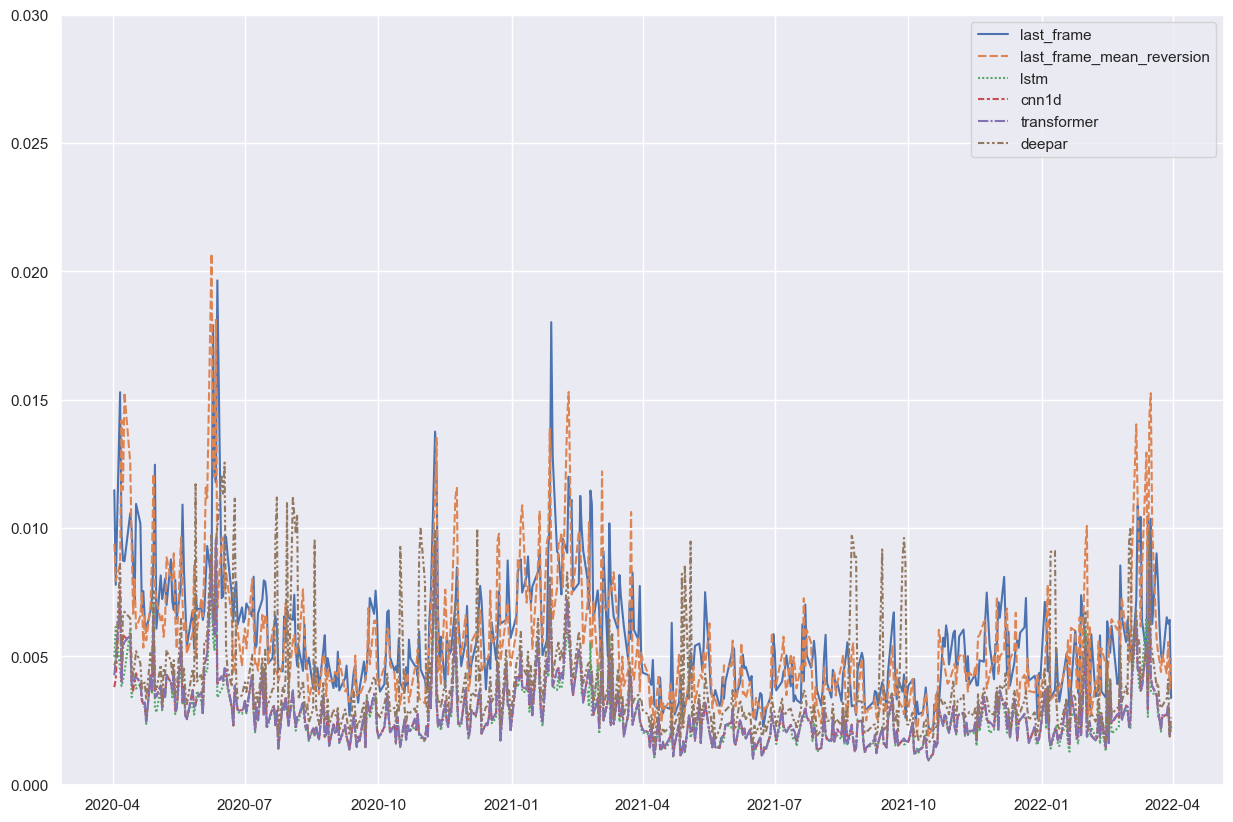

In [23]:
ax_train, mse_df_train = plot_mse(
    [
        y_pred_train_lf, y_pred_train_lfmr, y_pred_train_lstm, y_pred_train_cnn1d, 
        y_pred_train_transformer, y_pred_train_deepar
    ], y, 
    [
        'last_frame', 'last_frame_mean_reversion', 'lstm', 'cnn1d', 'transformer', 'deepar'
    ], 
    train_index
)

In [24]:
generate_report(
    [
        y_pred_train_lf, y_pred_train_lfmr, y_pred_train_lstm, y_pred_train_cnn1d, 
        y_pred_train_transformer, y_pred_train_deepar
    ], y, 
    [
        'last_frame', 'last_frame_mean_reversion', 'lstm', 'cnn1d', 'transformer', 'deepar'
    ]
)

,mse,corr,deviation
last_frame,0.005738,-0.014256,1.176668
last_frame_mean_reversion,0.005505,0.014256,1.157190
lstm,0.002684,0.219818,1.172452
cnn1d,0.002799,0.019006,1.164602
transformer,0.002802,0.017855,1.172356
deepar,0.003911,0.015882,1.355514


## test result

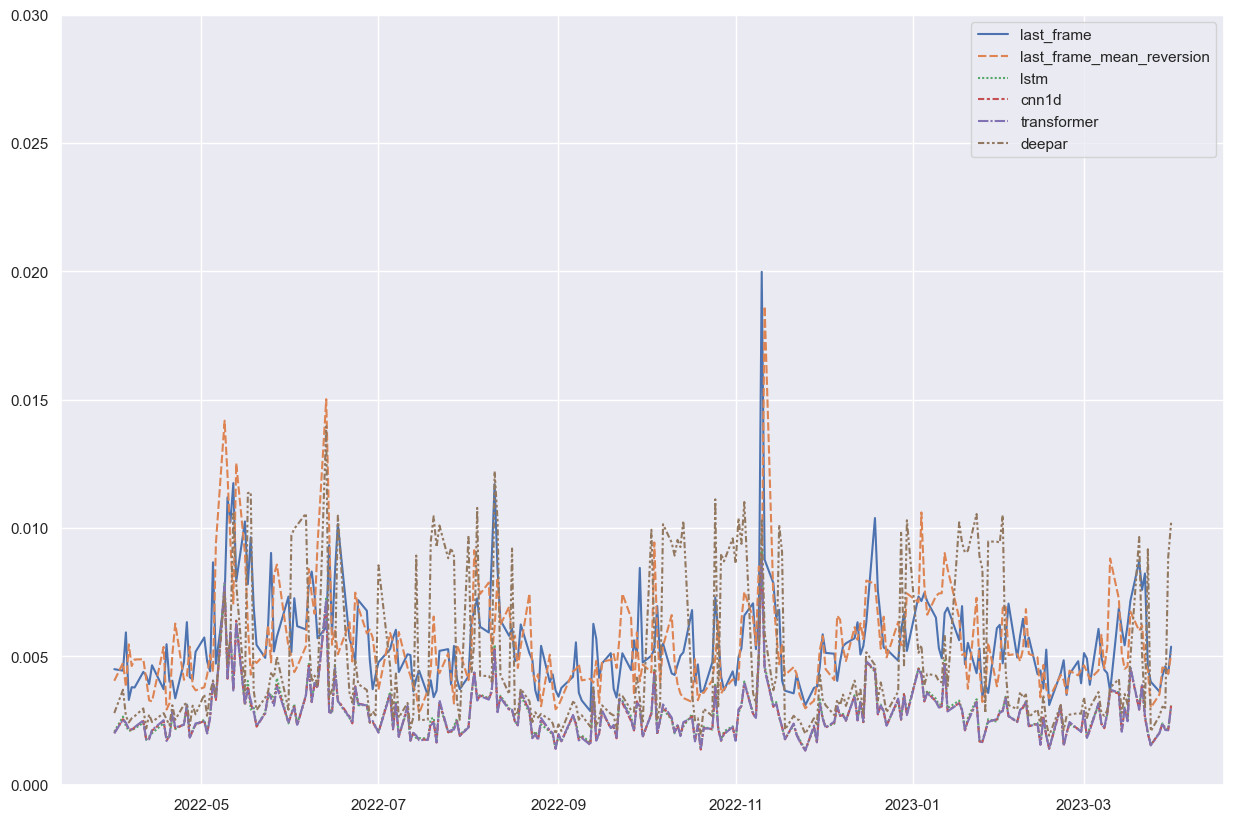

In [25]:
ax_test, mse_df_test = plot_mse(
    [
        y_pred_test_lf, y_pred_test_lfmr, y_pred_test_lstm, y_pred_test_cnn1d, 
        y_pred_test_transformer, y_pred_test_deepar
    ], y_test, 
    [
        'last_frame', 'last_frame_mean_reversion', 'lstm', 'cnn1d', 'transformer', 'deepar'
    ], 
    test_index
)

In [26]:
generate_report(
    [
        y_pred_test_lf, y_pred_test_lfmr, y_pred_test_lstm, y_pred_test_cnn1d, 
        y_pred_test_transformer, y_pred_test_deepar
    ], y_test, 
    [
        'last_frame', 'last_frame_mean_reversion', 'lstm', 'cnn1d', 'transformer', 'deepar'
    ]
)

,mse,corr,deviation
last_frame,0.005523,-0.011859,1.310278
last_frame_mean_reversion,0.005489,0.011859,1.300042
lstm,0.002793,0.001647,1.093366
cnn1d,0.002768,0.001111,1.068278
transformer,0.002773,0.010406,1.076971
deepar,0.004854,0.005872,1.307334
